In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torchviz import make_dot
from tqdm import tqdm

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)# cudaが利用可能だと0

cuda:0


In [32]:
# 最終的なデータセットの定義
data_root = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])
train_set = datasets.MNIST(
    root = data_root, train=True, download=False, transform=transform
)
test_set = datasets.MNIST(
    root = data_root, train=False, download=False, transform=transform
)

In [33]:
from torch.utils.data import DataLoader
batch_size=500

train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True
)
test_loader = DataLoader(
    test_set, batch_size = batch_size,
    shuffle = False
)

In [34]:
# 入出力、隠れ層の設定
image, label = train_set[0]
n_input = image.shape[0]
for images, labels in train_loader:
    break
n_output = len(set(list(labels.data.numpy())))
n_hidden = 128

In [35]:
# モデルの定義
# 784入力10出力２隠れ層のNNモデル
class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        # 隠れ層1
        self.l1 = nn.Linear(n_input, n_hidden)
        # 隠れ層2
        self.l2 = nn.Linear(n_hidden, n_hidden)
        # 出力層
        self.l3 = nn.Linear(n_hidden, n_output)
        # ReLU
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [36]:
# NN層の定義
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 学習率
lr = 0.01
# モデル初期化
net = Net2(n_input, n_output, n_hidden).to(device)
print(net)
# 損失関数：交差エントロピー関数
criterion = nn.CrossEntropyLoss()
# 最適化関数
optimizer = optim.SGD(net.parameters(), lr=lr)
# 繰り返し回数
num_epochs = 100
# 評価関数結果記録用
history = np.zeros((0,5))

Net2(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [37]:
# 繰り返し計算メインループ
for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)
        # GPUへ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 勾配の初期化
        optimizer.zero_grad()
        # 予測計算
        outputs = net(inputs)
        # 損失計算
        loss = criterion(outputs, labels)
        # 勾配計算
        loss.backward()
        # パラメータ修正
        optimizer.step()
        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]
        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item() 

    # 予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)
        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 予測計算
        outputs_test = net(inputs_test)

        # 損失関数
        loss_test = criterion(outputs_test, labels_test)

        # 予測データ導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と制度の計算
        val_loss += loss_test.item()
        val_acc += (predicted_test == labels_test).sum().item()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))
print(f'初期状態：損失：{history[0,3]:.5f}  精度：{history[0,4]:.5f}')
print(f'最終状態：損失：{history[-1,3]:.5f}  精度：{history[-1,4]:.5f}')

100%|██████████| 120/120 [00:02<00:00, 46.41it/s]


Epoch [1/100], loss: 2.20163 acc: 0.25380 val_loss: 2.04576, val_acc: 0.49800


100%|██████████| 120/120 [00:02<00:00, 54.63it/s]


Epoch [2/100], loss: 1.75820 acc: 0.60443 val_loss: 1.39273, val_acc: 0.68680


100%|██████████| 120/120 [00:02<00:00, 55.70it/s]


Epoch [3/100], loss: 1.11285 acc: 0.75645 val_loss: 0.86511, val_acc: 0.80810


100%|██████████| 120/120 [00:02<00:00, 55.68it/s]


Epoch [4/100], loss: 0.75171 acc: 0.82293 val_loss: 0.63478, val_acc: 0.84400


100%|██████████| 120/120 [00:02<00:00, 54.64it/s]


Epoch [5/100], loss: 0.59031 acc: 0.84987 val_loss: 0.52462, val_acc: 0.86360


100%|██████████| 120/120 [00:02<00:00, 55.00it/s]


Epoch [6/100], loss: 0.50672 acc: 0.86652 val_loss: 0.46400, val_acc: 0.87440


100%|██████████| 120/120 [00:02<00:00, 55.63it/s]


Epoch [7/100], loss: 0.45680 acc: 0.87542 val_loss: 0.42149, val_acc: 0.88560


100%|██████████| 120/120 [00:02<00:00, 55.73it/s]


Epoch [8/100], loss: 0.42335 acc: 0.88192 val_loss: 0.39550, val_acc: 0.89020


100%|██████████| 120/120 [00:02<00:00, 55.02it/s]


Epoch [9/100], loss: 0.39965 acc: 0.88768 val_loss: 0.37600, val_acc: 0.89360


100%|██████████| 120/120 [00:02<00:00, 54.80it/s]


Epoch [10/100], loss: 0.38195 acc: 0.89185 val_loss: 0.35886, val_acc: 0.89890


100%|██████████| 120/120 [00:02<00:00, 56.08it/s]


Epoch [11/100], loss: 0.36793 acc: 0.89473 val_loss: 0.34925, val_acc: 0.90350


100%|██████████| 120/120 [00:02<00:00, 55.75it/s]


Epoch [12/100], loss: 0.35633 acc: 0.89803 val_loss: 0.33760, val_acc: 0.90400


100%|██████████| 120/120 [00:02<00:00, 53.59it/s]


Epoch [13/100], loss: 0.34648 acc: 0.89965 val_loss: 0.32775, val_acc: 0.90580


100%|██████████| 120/120 [00:02<00:00, 55.15it/s]


Epoch [14/100], loss: 0.33814 acc: 0.90203 val_loss: 0.32063, val_acc: 0.90760


100%|██████████| 120/120 [00:02<00:00, 55.79it/s]


Epoch [15/100], loss: 0.33042 acc: 0.90458 val_loss: 0.31807, val_acc: 0.90760


100%|██████████| 120/120 [00:02<00:00, 56.02it/s]


Epoch [16/100], loss: 0.32382 acc: 0.90602 val_loss: 0.31015, val_acc: 0.91130


100%|██████████| 120/120 [00:02<00:00, 54.67it/s]


Epoch [17/100], loss: 0.31777 acc: 0.90757 val_loss: 0.30470, val_acc: 0.91140


100%|██████████| 120/120 [00:02<00:00, 55.13it/s]


Epoch [18/100], loss: 0.31206 acc: 0.90907 val_loss: 0.30014, val_acc: 0.91410


100%|██████████| 120/120 [00:02<00:00, 56.12it/s]


Epoch [19/100], loss: 0.30685 acc: 0.91080 val_loss: 0.29439, val_acc: 0.91420


100%|██████████| 120/120 [00:02<00:00, 55.98it/s]


Epoch [20/100], loss: 0.30213 acc: 0.91207 val_loss: 0.29149, val_acc: 0.91500


100%|██████████| 120/120 [00:02<00:00, 54.95it/s]


Epoch [21/100], loss: 0.29752 acc: 0.91375 val_loss: 0.28591, val_acc: 0.91640


100%|██████████| 120/120 [00:02<00:00, 54.53it/s]


Epoch [22/100], loss: 0.29328 acc: 0.91495 val_loss: 0.28178, val_acc: 0.91750


100%|██████████| 120/120 [00:02<00:00, 55.92it/s]


Epoch [23/100], loss: 0.28876 acc: 0.91610 val_loss: 0.27957, val_acc: 0.91850


100%|██████████| 120/120 [00:02<00:00, 56.19it/s]


Epoch [24/100], loss: 0.28524 acc: 0.91683 val_loss: 0.27463, val_acc: 0.92080


100%|██████████| 120/120 [00:02<00:00, 55.06it/s]


Epoch [25/100], loss: 0.28129 acc: 0.91832 val_loss: 0.27168, val_acc: 0.92150


100%|██████████| 120/120 [00:02<00:00, 54.73it/s]


Epoch [26/100], loss: 0.27771 acc: 0.91923 val_loss: 0.26891, val_acc: 0.92200


100%|██████████| 120/120 [00:02<00:00, 56.17it/s]


Epoch [27/100], loss: 0.27410 acc: 0.92005 val_loss: 0.26614, val_acc: 0.92380


100%|██████████| 120/120 [00:02<00:00, 55.55it/s]


Epoch [28/100], loss: 0.27079 acc: 0.92123 val_loss: 0.26244, val_acc: 0.92470


100%|██████████| 120/120 [00:02<00:00, 55.00it/s]


Epoch [29/100], loss: 0.26759 acc: 0.92230 val_loss: 0.26265, val_acc: 0.92320


100%|██████████| 120/120 [00:02<00:00, 55.08it/s]


Epoch [30/100], loss: 0.26483 acc: 0.92293 val_loss: 0.25895, val_acc: 0.92420


100%|██████████| 120/120 [00:02<00:00, 55.03it/s]


Epoch [31/100], loss: 0.26134 acc: 0.92375 val_loss: 0.25497, val_acc: 0.92660


100%|██████████| 120/120 [00:02<00:00, 55.69it/s]


Epoch [32/100], loss: 0.25842 acc: 0.92470 val_loss: 0.25227, val_acc: 0.92740


100%|██████████| 120/120 [00:02<00:00, 54.67it/s]


Epoch [33/100], loss: 0.25551 acc: 0.92568 val_loss: 0.25112, val_acc: 0.92570


100%|██████████| 120/120 [00:02<00:00, 55.84it/s]


Epoch [34/100], loss: 0.25279 acc: 0.92638 val_loss: 0.24733, val_acc: 0.92780


100%|██████████| 120/120 [00:02<00:00, 56.26it/s]


Epoch [35/100], loss: 0.24959 acc: 0.92753 val_loss: 0.24459, val_acc: 0.93060


100%|██████████| 120/120 [00:02<00:00, 55.84it/s]


Epoch [36/100], loss: 0.24676 acc: 0.92833 val_loss: 0.24468, val_acc: 0.92770


100%|██████████| 120/120 [00:02<00:00, 55.17it/s]


Epoch [37/100], loss: 0.24410 acc: 0.92962 val_loss: 0.24132, val_acc: 0.92830


100%|██████████| 120/120 [00:02<00:00, 55.81it/s]


Epoch [38/100], loss: 0.24158 acc: 0.93008 val_loss: 0.23741, val_acc: 0.93210


100%|██████████| 120/120 [00:02<00:00, 56.00it/s]


Epoch [39/100], loss: 0.23886 acc: 0.93112 val_loss: 0.23472, val_acc: 0.93290


100%|██████████| 120/120 [00:02<00:00, 55.90it/s]


Epoch [40/100], loss: 0.23617 acc: 0.93163 val_loss: 0.23369, val_acc: 0.93230


100%|██████████| 120/120 [00:02<00:00, 54.78it/s]


Epoch [41/100], loss: 0.23374 acc: 0.93220 val_loss: 0.22987, val_acc: 0.93330


100%|██████████| 120/120 [00:02<00:00, 55.97it/s]


Epoch [42/100], loss: 0.23095 acc: 0.93273 val_loss: 0.22864, val_acc: 0.93260


100%|██████████| 120/120 [00:02<00:00, 55.75it/s]


Epoch [43/100], loss: 0.22849 acc: 0.93407 val_loss: 0.22668, val_acc: 0.93570


100%|██████████| 120/120 [00:02<00:00, 56.30it/s]


Epoch [44/100], loss: 0.22612 acc: 0.93478 val_loss: 0.22333, val_acc: 0.93500


100%|██████████| 120/120 [00:02<00:00, 55.36it/s]


Epoch [45/100], loss: 0.22344 acc: 0.93502 val_loss: 0.22107, val_acc: 0.93450


100%|██████████| 120/120 [00:02<00:00, 56.65it/s]


Epoch [46/100], loss: 0.22104 acc: 0.93585 val_loss: 0.21980, val_acc: 0.93630


100%|██████████| 120/120 [00:02<00:00, 55.30it/s]


Epoch [47/100], loss: 0.21872 acc: 0.93682 val_loss: 0.21707, val_acc: 0.93650


100%|██████████| 120/120 [00:02<00:00, 56.10it/s]


Epoch [48/100], loss: 0.21632 acc: 0.93758 val_loss: 0.21635, val_acc: 0.93730


100%|██████████| 120/120 [00:02<00:00, 54.87it/s]


Epoch [49/100], loss: 0.21397 acc: 0.93832 val_loss: 0.21387, val_acc: 0.93850


100%|██████████| 120/120 [00:02<00:00, 56.28it/s]


Epoch [50/100], loss: 0.21180 acc: 0.93883 val_loss: 0.21027, val_acc: 0.93730


100%|██████████| 120/120 [00:02<00:00, 54.95it/s]


Epoch [51/100], loss: 0.20945 acc: 0.93945 val_loss: 0.20931, val_acc: 0.93890


100%|██████████| 120/120 [00:02<00:00, 55.94it/s]


Epoch [52/100], loss: 0.20724 acc: 0.94018 val_loss: 0.20953, val_acc: 0.93580


100%|██████████| 120/120 [00:02<00:00, 55.18it/s]


Epoch [53/100], loss: 0.20506 acc: 0.94080 val_loss: 0.20476, val_acc: 0.94080


100%|██████████| 120/120 [00:02<00:00, 55.77it/s]


Epoch [54/100], loss: 0.20266 acc: 0.94135 val_loss: 0.20285, val_acc: 0.93920


100%|██████████| 120/120 [00:02<00:00, 55.02it/s]


Epoch [55/100], loss: 0.20043 acc: 0.94232 val_loss: 0.20080, val_acc: 0.94170


100%|██████████| 120/120 [00:02<00:00, 55.66it/s]


Epoch [56/100], loss: 0.19844 acc: 0.94272 val_loss: 0.19841, val_acc: 0.94190


100%|██████████| 120/120 [00:02<00:00, 54.92it/s]


Epoch [57/100], loss: 0.19653 acc: 0.94388 val_loss: 0.19673, val_acc: 0.94180


100%|██████████| 120/120 [00:02<00:00, 56.22it/s]


Epoch [58/100], loss: 0.19422 acc: 0.94397 val_loss: 0.19496, val_acc: 0.94230


100%|██████████| 120/120 [00:02<00:00, 54.08it/s]


Epoch [59/100], loss: 0.19227 acc: 0.94442 val_loss: 0.19378, val_acc: 0.94300


100%|██████████| 120/120 [00:02<00:00, 55.44it/s]


Epoch [60/100], loss: 0.19031 acc: 0.94535 val_loss: 0.19109, val_acc: 0.94330


100%|██████████| 120/120 [00:02<00:00, 55.25it/s]


Epoch [61/100], loss: 0.18842 acc: 0.94563 val_loss: 0.18999, val_acc: 0.94430


100%|██████████| 120/120 [00:02<00:00, 55.97it/s]


Epoch [62/100], loss: 0.18623 acc: 0.94683 val_loss: 0.18821, val_acc: 0.94440


100%|██████████| 120/120 [00:02<00:00, 55.02it/s]


Epoch [63/100], loss: 0.18460 acc: 0.94672 val_loss: 0.18560, val_acc: 0.94490


100%|██████████| 120/120 [00:02<00:00, 55.90it/s]


Epoch [64/100], loss: 0.18267 acc: 0.94703 val_loss: 0.18448, val_acc: 0.94500


100%|██████████| 120/120 [00:02<00:00, 56.08it/s]


Epoch [65/100], loss: 0.18072 acc: 0.94803 val_loss: 0.18252, val_acc: 0.94570


100%|██████████| 120/120 [00:02<00:00, 55.93it/s]


Epoch [66/100], loss: 0.17906 acc: 0.94830 val_loss: 0.18065, val_acc: 0.94530


100%|██████████| 120/120 [00:02<00:00, 54.92it/s]


Epoch [67/100], loss: 0.17725 acc: 0.94927 val_loss: 0.17930, val_acc: 0.94620


100%|██████████| 120/120 [00:02<00:00, 56.24it/s]


Epoch [68/100], loss: 0.17531 acc: 0.94970 val_loss: 0.17715, val_acc: 0.94670


100%|██████████| 120/120 [00:02<00:00, 55.68it/s]


Epoch [69/100], loss: 0.17379 acc: 0.94982 val_loss: 0.17559, val_acc: 0.94850


100%|██████████| 120/120 [00:02<00:00, 55.29it/s]


Epoch [70/100], loss: 0.17195 acc: 0.95055 val_loss: 0.17434, val_acc: 0.94790


100%|██████████| 120/120 [00:02<00:00, 54.96it/s]


Epoch [71/100], loss: 0.17031 acc: 0.95118 val_loss: 0.17267, val_acc: 0.94840


100%|██████████| 120/120 [00:02<00:00, 56.34it/s]


Epoch [72/100], loss: 0.16848 acc: 0.95135 val_loss: 0.17089, val_acc: 0.94890


100%|██████████| 120/120 [00:02<00:00, 55.87it/s]


Epoch [73/100], loss: 0.16689 acc: 0.95197 val_loss: 0.17038, val_acc: 0.94960


100%|██████████| 120/120 [00:02<00:00, 54.53it/s]


Epoch [74/100], loss: 0.16519 acc: 0.95253 val_loss: 0.16924, val_acc: 0.95030


100%|██████████| 120/120 [00:02<00:00, 54.85it/s]


Epoch [75/100], loss: 0.16374 acc: 0.95277 val_loss: 0.16796, val_acc: 0.94960


100%|██████████| 120/120 [00:02<00:00, 56.17it/s]


Epoch [76/100], loss: 0.16228 acc: 0.95357 val_loss: 0.16560, val_acc: 0.95130


100%|██████████| 120/120 [00:02<00:00, 56.20it/s]


Epoch [77/100], loss: 0.16060 acc: 0.95375 val_loss: 0.16513, val_acc: 0.95150


100%|██████████| 120/120 [00:02<00:00, 54.94it/s]


Epoch [78/100], loss: 0.15917 acc: 0.95433 val_loss: 0.16285, val_acc: 0.95140


100%|██████████| 120/120 [00:02<00:00, 54.95it/s]


Epoch [79/100], loss: 0.15768 acc: 0.95457 val_loss: 0.16262, val_acc: 0.95160


100%|██████████| 120/120 [00:02<00:00, 55.90it/s]


Epoch [80/100], loss: 0.15609 acc: 0.95528 val_loss: 0.16006, val_acc: 0.95300


100%|██████████| 120/120 [00:02<00:00, 56.62it/s]


Epoch [81/100], loss: 0.15466 acc: 0.95563 val_loss: 0.15931, val_acc: 0.95280


100%|██████████| 120/120 [00:02<00:00, 54.64it/s]


Epoch [82/100], loss: 0.15333 acc: 0.95593 val_loss: 0.15824, val_acc: 0.95270


100%|██████████| 120/120 [00:02<00:00, 55.24it/s]


Epoch [83/100], loss: 0.15187 acc: 0.95628 val_loss: 0.15677, val_acc: 0.95310


100%|██████████| 120/120 [00:02<00:00, 55.86it/s]


Epoch [84/100], loss: 0.15063 acc: 0.95692 val_loss: 0.15558, val_acc: 0.95400


100%|██████████| 120/120 [00:02<00:00, 55.41it/s]


Epoch [85/100], loss: 0.14918 acc: 0.95717 val_loss: 0.15528, val_acc: 0.95390


100%|██████████| 120/120 [00:02<00:00, 55.02it/s]


Epoch [86/100], loss: 0.14785 acc: 0.95780 val_loss: 0.15300, val_acc: 0.95400


100%|██████████| 120/120 [00:02<00:00, 55.19it/s]


Epoch [87/100], loss: 0.14652 acc: 0.95778 val_loss: 0.15198, val_acc: 0.95440


100%|██████████| 120/120 [00:02<00:00, 55.98it/s]


Epoch [88/100], loss: 0.14521 acc: 0.95835 val_loss: 0.15013, val_acc: 0.95480


100%|██████████| 120/120 [00:02<00:00, 55.84it/s]


Epoch [89/100], loss: 0.14407 acc: 0.95882 val_loss: 0.14954, val_acc: 0.95510


100%|██████████| 120/120 [00:02<00:00, 54.88it/s]


Epoch [90/100], loss: 0.14250 acc: 0.95918 val_loss: 0.14936, val_acc: 0.95520


100%|██████████| 120/120 [00:02<00:00, 54.89it/s]


Epoch [91/100], loss: 0.14150 acc: 0.95970 val_loss: 0.14765, val_acc: 0.95550


100%|██████████| 120/120 [00:02<00:00, 55.66it/s]


Epoch [92/100], loss: 0.14013 acc: 0.95967 val_loss: 0.14764, val_acc: 0.95580


100%|██████████| 120/120 [00:02<00:00, 56.19it/s]


Epoch [93/100], loss: 0.13901 acc: 0.96018 val_loss: 0.14747, val_acc: 0.95630


100%|██████████| 120/120 [00:02<00:00, 54.67it/s]


Epoch [94/100], loss: 0.13765 acc: 0.96060 val_loss: 0.14508, val_acc: 0.95630


100%|██████████| 120/120 [00:02<00:00, 54.89it/s]


Epoch [95/100], loss: 0.13663 acc: 0.96097 val_loss: 0.14404, val_acc: 0.95620


100%|██████████| 120/120 [00:02<00:00, 55.73it/s]


Epoch [96/100], loss: 0.13548 acc: 0.96137 val_loss: 0.14406, val_acc: 0.95680


100%|██████████| 120/120 [00:02<00:00, 56.10it/s]


Epoch [97/100], loss: 0.13420 acc: 0.96170 val_loss: 0.14099, val_acc: 0.95680


100%|██████████| 120/120 [00:02<00:00, 54.81it/s]


Epoch [98/100], loss: 0.13313 acc: 0.96207 val_loss: 0.14104, val_acc: 0.95700


100%|██████████| 120/120 [00:02<00:00, 55.86it/s]


Epoch [99/100], loss: 0.13193 acc: 0.96237 val_loss: 0.13979, val_acc: 0.95710


100%|██████████| 120/120 [00:02<00:00, 55.82it/s]


Epoch [100/100], loss: 0.13093 acc: 0.96287 val_loss: 0.13874, val_acc: 0.95820
初期状態：損失：2.04576  精度：0.49800
最終状態：損失：0.13874  精度：0.95820


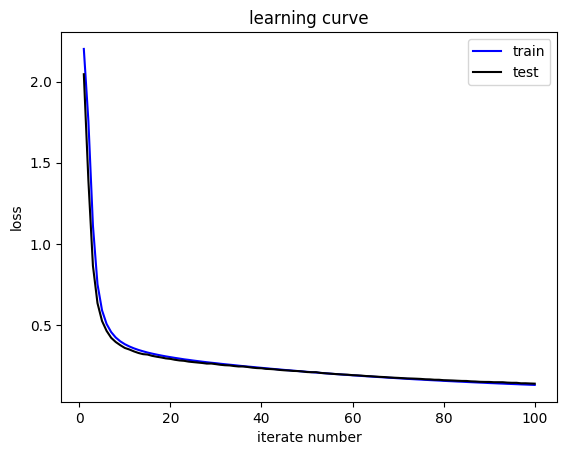

In [38]:
# 学習曲線の表示(損失)
plt.plot(history[:,0], history[:,1], "b", label="train")
plt.plot(history[:,0], history[:,3], "k", label="test")
plt.xlabel('iterate number')
plt.ylabel('loss')
plt.title('learning curve')
plt.legend()
plt.show()

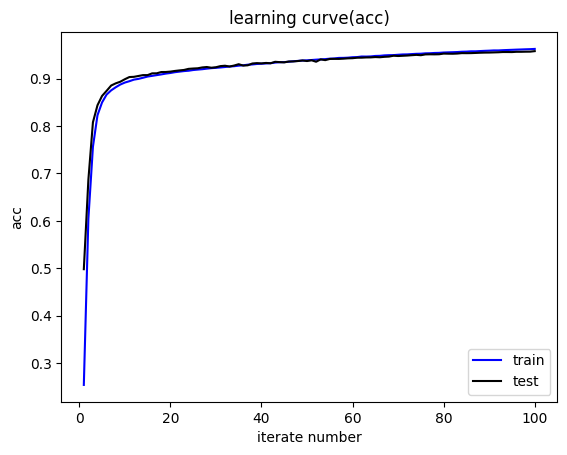

In [39]:
# 学習曲線の表示(精度)
plt.plot(history[:,0], history[:,2], "b", label="train")
plt.plot(history[:,0], history[:,4], "k", label="test")
plt.xlabel('iterate number')
plt.ylabel('acc')
plt.title('learning curve(acc)')
plt.legend()
plt.show()